In [2]:
# Imports

import numpy as np
from tqdm import tqdm
import random
import gym
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display, clear_output
import time

Number of states in Taxi environment: 500
Current state: 291
2 4 2 3
Number of actions that an agent can take: 6
Next state: 191
Reward recieved: -1
Done: False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


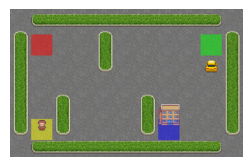

In [3]:
# Environment setup

# Create the Taxi-v3 environment
env = gym.make('Taxi-v3',new_step_api=True)

# Get the number of states in the environment
num_states = env.observation_space.n
print ("Number of states in Taxi environment:", num_states)

state = env.reset()
print('Current state:', state)

taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)
print(taxi_row, taxi_col, pass_loc, dest_loc)

# Primitive Actions
action = ["south", "north", "east", "west", "pick", "drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

locations = ['R','G','Y','B','On Taxi']

num_actions = env.action_space.n
print ("Number of actions that an agent can take:", num_actions)

# Example Transitions
# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)
#print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Done:", done)

plt.figure(figsize=(3, 3))
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.show()


In [4]:
# Epsilon Greedy Definition

# TODO: epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
  if random.random() < epsilon:
        # Explore: Select a random action
        action = random.randint(0, q_values.shape[1] - 1)
  else:
      # Exploit: Select the action with the highest Q-value
      action = np.argmax(q_values[state])

  return action

In [5]:
# Define Options

# We are defining four more options here
# Option R ["Red"] - > Move towards Red
# Option G ["Green"] - > Move towards Green
# Option Y ["Yellow"] - > Move towards Yellow
# Option B ["Blue"] - > Move towards Blue


def Red(env,state):

    optdone = False
    taxi_row, taxi_col, _, _ = env.decode(state)

    red_grid = np.array([
                        [1, 3, 0, 0, 0],
                        [1, 3, 3, 3, 3],
                        [1, 3, 3, 3, 3],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1]
                        ])

    optact = red_grid[taxi_row,taxi_col]

    if (taxi_row, taxi_col) == (0,0):
        optdone = True

    return [optact, optdone]


def Green(env,state):

    optdone = False
    taxi_row, taxi_col, _, _ = env.decode(state)

    green_grid = np.array([
                        [0, 0, 2, 2, 1],
                        [2, 2, 2, 2, 1],
                        [2, 2, 2, 2, 1],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1]
                        ])

    optact = green_grid[taxi_row,taxi_col]

    if (taxi_row, taxi_col) == (0,4):
        optdone = True

    return [optact, optdone]


def Yellow(env,state):

    optdone = False
    taxi_row, taxi_col, _, _ = env.decode(state)

    yellow_grid = np.array([
                        [0, 0, 0, 0, 0],
                        [0, 3, 3, 3, 3],
                        [0, 3, 3, 3, 3],
                        [0, 1, 1, 1, 1],
                        [0, 1, 1, 1, 1]
                        ])

    optact = yellow_grid[taxi_row,taxi_col]

    if (taxi_row, taxi_col) == (4,0):
        optdone = True

    return [optact, optdone]


def Blue(env,state):

    optdone = False
    taxi_row, taxi_col, _, _ = env.decode(state)

    blue_grid = np.array([
                        [0, 0, 2, 0, 3],
                        [2, 2, 2, 0, 3],
                        [2, 2, 2, 0, 3],
                        [1, 1, 1, 0, 3],
                        [1, 1, 1, 0, 3]
                        ])

    optact = blue_grid[taxi_row,taxi_col]

    if (taxi_row, taxi_col) == (4,3):
        optdone = True

    return [optact, optdone]

all_options = ["south", "north", "east", "west", "pick", "drop", "Red","Green","Yellow","Blue"]

'''
Now the new action space will contain
Primitive Actions: ["south", "north", "east", "west", "pick", "drop"]
Options: ["Red","Green","Yellow","Blue"]
Total Actions :["south", "north", "east", "west", "pick", "drop", "Red","Green","Yellow","Blue"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["south", "north", "east", "west", "pick", "drop"]\nOptions: ["Red","Green","Yellow","Blue"]\nTotal Actions :["south", "north", "east", "west", "pick", "drop", "Red","Green","Yellow","Blue"]\nCorresponding to [0,1,2,3,4,5,6,7,8,9]\n'

In [6]:
# SMDP Q-Learning - Run for 5 times

run_rewards = []

for run in range(5):

    print('Run:',run+1)

    #Q-Table: (States x Actions) === (env.ns(500) x total actions(10))
    q_values_SMDP = np.zeros((500,10))

    # Add parameters you might need here
    gamma = 0.9
    alpha = 0.1  # Learning rate
    epsilon = 0.1

    episodic_rewards = []

    # Iterate over 10000 episodes
    for ep in tqdm(range(10000)):

        state = env.reset()
        done = False
        episode_reward = 0

        taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)
        """
        print('Episode:',ep)
        print('Initial State:',state)
        print("Initial Taxi location:",taxi_row, taxi_col)
        print("Initial Passenger location:", locations[pass_loc])
        print("Destination:", locations[dest_loc])"""

        #Run for maximum timesteps
        ts = 0
        #for ts in range(100):
        while ts < 100:

            # Choose action
            action = egreedy_policy(q_values_SMDP, state, epsilon=epsilon)

            taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)

            # Checking if primitive action
            if action < 6:

                """# For debugging
                # Decode the state to get information about the taxi, passenger location, and destination
                taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)

                print('Timestep:', ts)
                print("Taxi location:",taxi_row, taxi_col)
                print("Action:", all_options[int(action)])
                print("Passenger location:", locations[pass_loc])
                print("Destination:", locations[dest_loc])
                # Till this"""

                # Perform regular Q-Learning update for state-action pair
                next_state, reward, done, _, _ = env.step(action)
                q_values_SMDP[state, action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])

                state = next_state
                episode_reward += reward


            # Checking if action chosen is an option


            if (taxi_row, taxi_col) != (0,0) and action == 6: # action => Red option
                reward_bar = 0
                opt_ts = 0

                optdone = False
                while (optdone == False):

                    """# For debugging
                    # Decode the state to get information about the taxi, passenger location, and destination
                    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)

                    print('Timestep:', ts)
                    print("Taxi location:",taxi_row, taxi_col)
                    print("Action:", all_options[int(action)])
                    print("Passenger location:", locations[pass_loc])
                    print("Destination:", locations[dest_loc])
                    # Till this"""


                    optact,optdone = Red(env,state)
                    """print('Optact:',all_options[optact])
                    print('Optdone:',optdone)"""
                    next_state, reward, done, _, _ = env.step(optact)


                    reward_bar = gamma*reward_bar + reward

                    state = next_state

                    opt_ts += 1
                    ts += 1

                    if opt_ts > 8:
                        break

                # Complete SMDP Q-Learning Update
                q_values_SMDP[state, action] += alpha * (reward_bar + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])


                episode_reward += reward_bar


            if (taxi_row, taxi_col) != (0,4) and action == 7: # action => Green option
                reward_bar = 0
                opt_ts = 0
                optdone = False
                while (optdone == False):

                    """# For debugging
                    # Decode the state to get information about the taxi, passenger location, and destination
                    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)


                    print('Timestep:', ts)
                    print("Taxi location:",taxi_row, taxi_col)
                    print("Action:", all_options[int(action)])
                    print("Passenger location:", locations[pass_loc])
                    print("Destination:", locations[dest_loc])
                    # Till this"""

                    optact,optdone = Green(env,state)
                    """print('Optact:',all_options[optact])
                    print('Optdone:',optdone)"""
                    next_state, reward, done, _, _ = env.step(optact)

                    reward_bar = gamma*reward_bar + reward

                    state = next_state

                    opt_ts += 1
                    ts += 1

                    if opt_ts > 8:
                        break

                # Complete SMDP Q-Learning Update
                q_values_SMDP[state, action] += alpha * (reward_bar + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])


                episode_reward += reward_bar


            if (taxi_row, taxi_col) != (4,0) and action == 8: # action => Yellow option
                reward_bar = 0
                opt_ts = 0
                optdone = False
                while (optdone == False):

                    """# For debugging
                    # Decode the state to get information about the taxi, passenger location, and destination
                    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)

                    print('Timestep:', ts)
                    print("Taxi location:",taxi_row, taxi_col)
                    print("Action:", all_options[int(action)])
                    print("Passenger location:", locations[pass_loc])
                    print("Destination:", locations[dest_loc])
                    # Till this"""

                    optact,optdone = Yellow(env,state)
                    """print('Optact:',all_options[optact])
                    print('Optdone:',optdone)"""
                    next_state, reward, done, _, _ = env.step(optact)

                    reward_bar = gamma*reward_bar + reward

                    state = next_state

                    opt_ts += 1
                    ts += 1

                    if opt_ts > 8:
                        break

                # Complete SMDP Q-Learning Update
                q_values_SMDP[state, action] += alpha * (reward_bar + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])


                episode_reward += reward_bar


            if (taxi_row, taxi_col) != (4,3) and action == 9: # action => Blue option
                reward_bar = 0
                opt_ts = 0
                optdone = False
                while (optdone == False):

                    """# For debugging
                    # Decode the state to get information about the taxi, passenger location, and destination
                    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)


                    print('Timestep:', ts)
                    print("Taxi location:",taxi_row, taxi_col)
                    print("Action:", all_options[int(action)])
                    print("Passenger location:", locations[pass_loc])
                    print("Destination:", locations[dest_loc])
                    # Till this"""

                    optact,optdone = Blue(env,state)
                    """print('Optact:',all_options[optact])
                    print('Optdone:',optdone)"""
                    next_state, reward, done, _, _ = env.step(optact)

                    reward_bar = gamma*reward_bar + reward

                    state = next_state

                    opt_ts += 1
                    ts += 1

                    if opt_ts > 8:
                        break

                # Complete SMDP Q-Learning Update
                q_values_SMDP[state, action] += alpha * (reward_bar + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])

                episode_reward += reward_bar
            ts += 1
            if episode_reward > 15:
                break

        episodic_rewards.append(episode_reward)

    run_rewards.append(episodic_rewards)


Run: 1


100%|██████████| 10000/10000 [00:41<00:00, 241.14it/s]


Run: 2


100%|██████████| 10000/10000 [00:40<00:00, 244.06it/s]


Run: 3


100%|██████████| 10000/10000 [00:40<00:00, 249.45it/s]


Run: 4


100%|██████████| 10000/10000 [00:40<00:00, 249.45it/s]


Run: 5


100%|██████████| 10000/10000 [00:40<00:00, 247.59it/s]


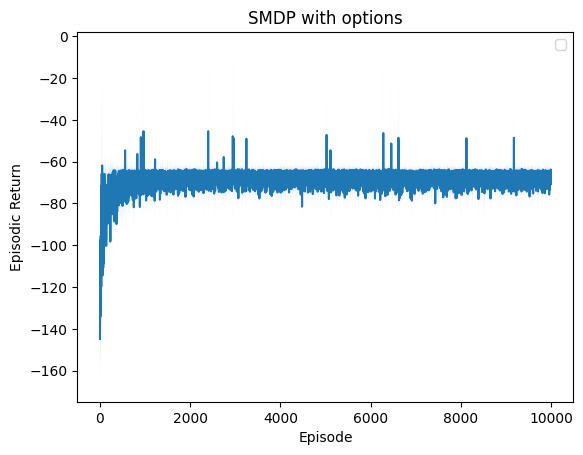

In [10]:
# Plot reward curve

run_rewards = np.array(run_rewards)

mean_returns = np.mean(run_rewards, axis=0)
std_returns = np.std(run_rewards, axis=0)

plt.plot(mean_returns)
plt.fill_between(range(len(mean_returns)), mean_returns - std_returns, mean_returns + std_returns, alpha=0.3)

plt.title('SMDP with options')
plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


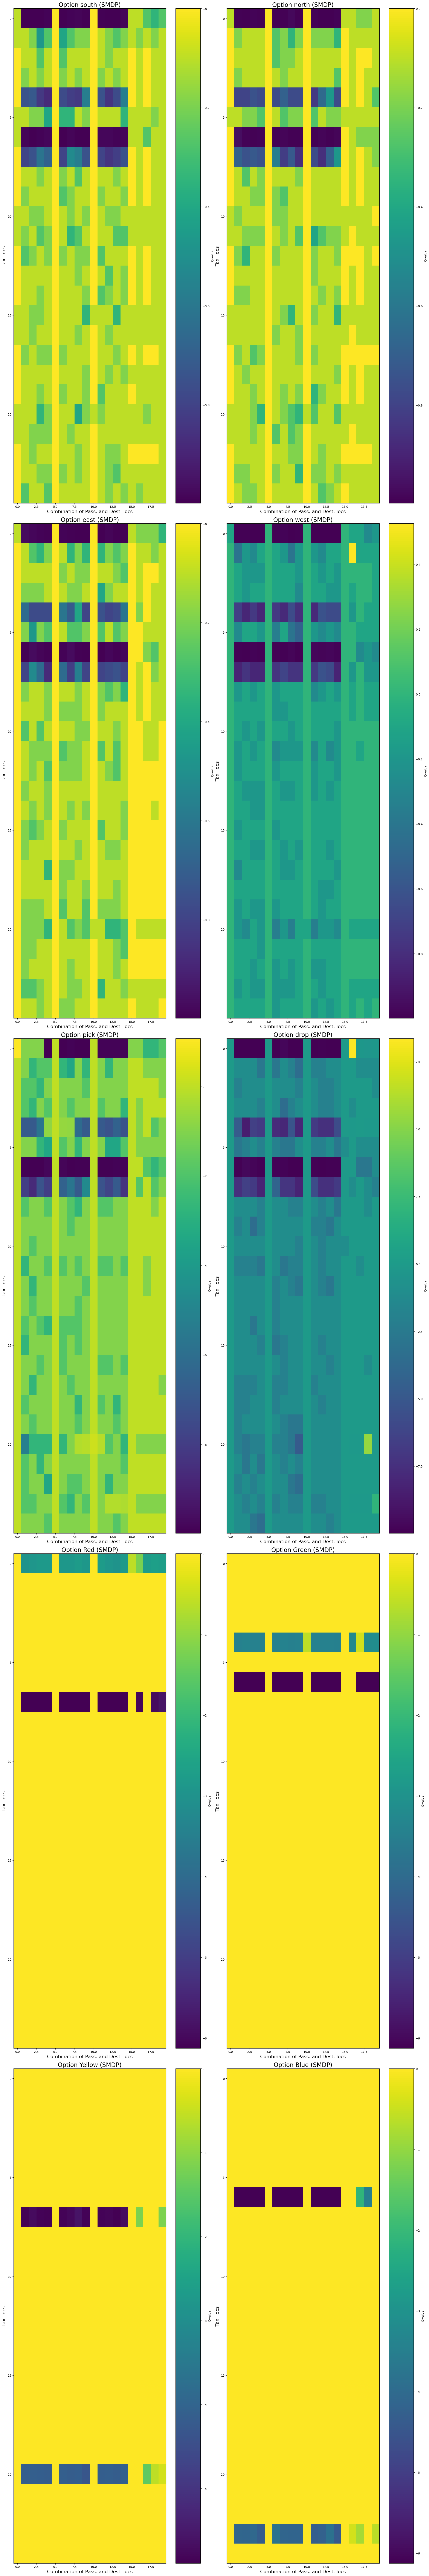

In [16]:
# Plot Q Table for each option

# Slice the second dimension of q_values_SMDP into 10 one-dimensional arrays
q_values_slices = [q_values_SMDP[:, i] for i in range(10)]

# Reshape the one-dimensional arrays into 2D arrays of shape (25, 20)
q_values_2d = [q.reshape(25, 20) for q in q_values_slices]

# Plot each of the 2D arrays
plt.figure(figsize=(20, 120))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(q_values_2d[i], cmap='viridis', aspect='auto')
    plt.colorbar(label='Q-value')
    plt.title(f'Option {all_options[i]} (SMDP)',fontsize=20)
    plt.xlabel('Combination of Pass. and Dest. locs',fontsize=16)
    plt.ylabel('Taxi locs',fontsize=16)

plt.tight_layout()
plt.show()

